In [1]:
#pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sea
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing

In [2]:
df = pd.read_csv('Mall_Customers.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
logtransformer = FunctionTransformer(np.log1p, validate=True) #np.log1p for small numbers

In [5]:
categ = df.select_dtypes(include=['object']).columns.tolist()

# Encode Categorical Columns
le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)
print(categ)

['Gender']


In [6]:
#income and age is generally skew which is bad for KNN, well log transform to reduce skew
norm_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('log', logtransformer),
    ('nscale', Normalizer())
])
    
std_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('stdscale', StandardScaler())    
])

cat_pipeline = Pipeline([
    ('impute', IterativeImputer(estimator=RandomForestClassifier(), 
                               initial_strategy='most_frequent',
                               max_iter=10, random_state=0)),
    ('OHE', OneHotEncoder(drop="if_binary"))    
])


preprocess_pipeline = ColumnTransformer([
    ('normalized', norm_pipeline, ['Annual Income (k$)', 'Age']),
    ('standardized', std_pipeline, ['Spending Score (1-100)']),
    ('categorical', cat_pipeline, ['Gender'])
])


In [7]:
print(df)

     CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1       1   19                  15                      39
1             2       1   21                  15                      81
2             3       0   20                  16                       6
3             4       0   23                  16                      77
4             5       0   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196       0   35                 120                      79
196         197       0   45                 126                      28
197         198       1   32                 126                      74
198         199       1   32                 137                      18
199         200       1   30                 137                      83

[200 rows x 5 columns]


In [8]:
preprocess_pipeline.fit_transform(df)


array([[ 0.67924479,  0.73391179, -0.43480148,  1.        ],
       [ 0.6677198 ,  0.7444127 ,  1.19570407,  1.        ],
       [ 0.68124565,  0.73205489, -1.71591298,  0.        ],
       [ 0.66544908,  0.74644325,  1.04041783,  0.        ],
       [ 0.64047971,  0.76797509, -0.39597992,  0.        ],
       [ 0.67778228,  0.73526266,  1.00159627,  0.        ],
       [ 0.63484681,  0.77263804, -1.71591298,  0.        ],
       [ 0.67963126,  0.73355391,  1.70038436,  0.        ],
       [ 0.58304448,  0.81244024, -1.83237767,  1.        ],
       [ 0.6573845 ,  0.75355532,  0.84631002,  0.        ],
       [ 0.57890673,  0.81539377, -1.4053405 ,  1.        ],
       [ 0.64137974,  0.76722358,  1.89449216,  0.        ],
       [ 0.59828433,  0.80128388, -1.36651894,  0.        ],
       [ 0.68715696,  0.72650899,  1.04041783,  0.        ],
       [ 0.64182528,  0.7668509 , -1.44416206,  1.        ],
       [ 0.69662248,  0.71743789,  1.11806095,  1.        ],
       [ 0.65315803,  0.

C:\Users\mdelan02\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Inertia')

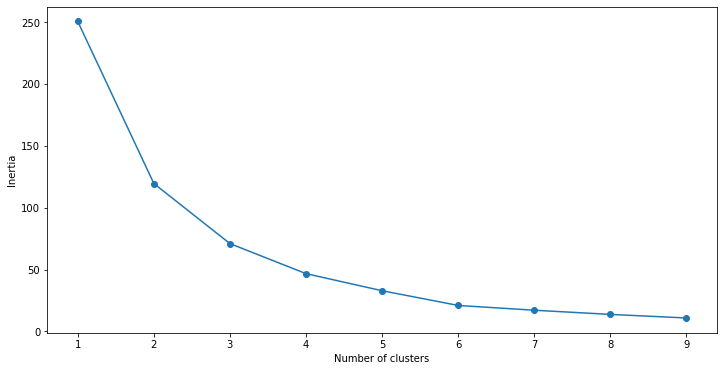

In [14]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    pipe = Pipeline([('preprocess',preprocess_pipeline), ('clf',kmeans)])
    pipe.fit(df)
    SSE.append(pipe['clf'].inertia_)

# converting the results into a dataframe and plotting them
#plotting to find the elbow of the figure which is the optimal # of clusters

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [15]:
#function to find knees if visual is difficult
kneecheck = KneeLocator(frame['Cluster'],frame['SSE'],curve ='convex',direction='decreasing')

OptimalClusters = kneecheck.knee
#OptimalClusters = 4
print(OptimalClusters)

3


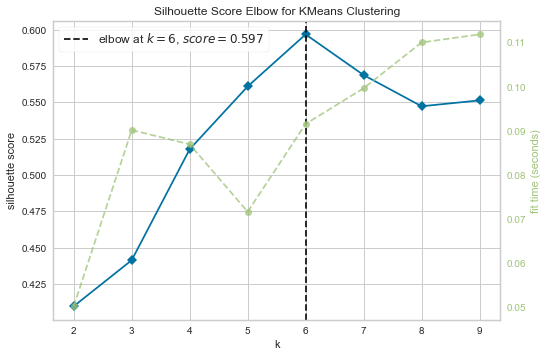

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [22]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(pipe['clf'], k=(2,10),metric='silhouette')
visualizer.fit(pipe['preprocess'].fit_transform(df))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [28]:
visualizer.elbow_value_

6

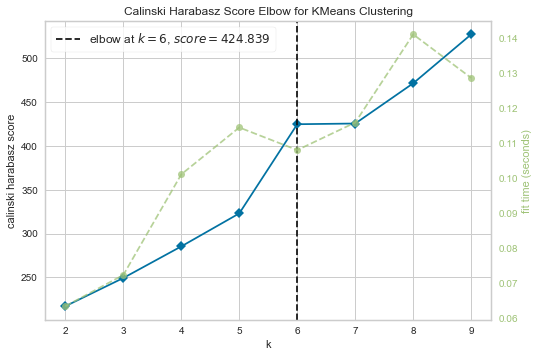

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [25]:
visualizer = KElbowVisualizer(pipe['clf'], k=(2,10),metric='calinski_harabasz')
visualizer.fit(pipe['preprocess'].fit_transform(df))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

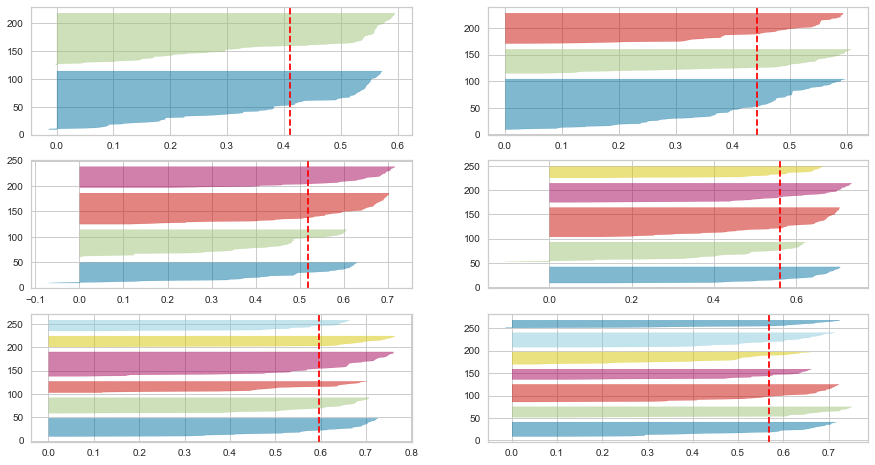

In [157]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pipe["preprocess"].transform(df)) 

In [158]:
#Finding the silhouette score
#newdf = newdf.drop(['label'], axis=1, errors='ignore')
kmeans = KMeans(n_clusters = OptimalClusters, init='k-means++')

pipe = Pipeline([('preprocess',preprocess_pipeline), ('kmeans',kmeans)])
pipe.fit(df)

preprocessed_data_pre = pipe["preprocess"].transform(df)
predicted_labels_pre = pipe["kmeans"].labels_

#print the silhouette score of this model (-1 to 1, 1 being highest)

print(silhouette_score(preprocessed_data_pre, predicted_labels_pre, metric='euclidean'))

0.5178061612639743


In [159]:
#get labels

df["label"] = pipe["kmeans"].labels_

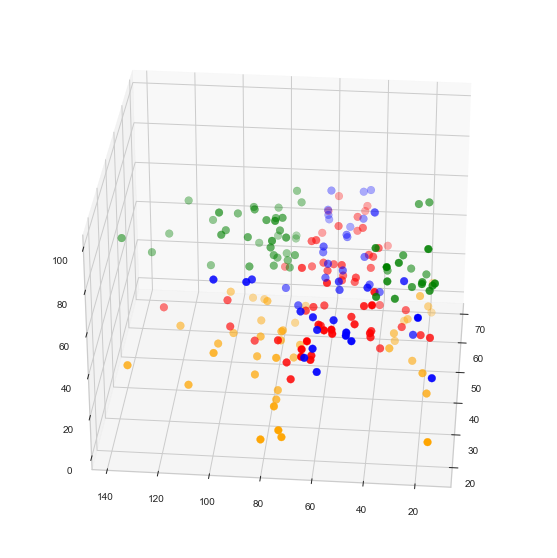

In [160]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)

ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

In [161]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),label
0,1,1,19,15,39,0
1,2,1,21,15,81,2
2,3,0,20,16,6,3
3,4,0,23,16,77,2
4,5,0,31,17,40,1


In [162]:
newdf = df.copy()
newdf.drop('CustomerID', axis=1, inplace=True)
newdf.drop('label', axis=1, inplace=True)

In [163]:
newdf.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [164]:
pca = PCA(n_components=2)

preprocess_pipeline_pca = ColumnTransformer([
    ('standardized', std_pipeline, ['Spending Score (1-100)','Annual Income (k$)', 'Age']),
    ('categorical', cat_pipeline, ['Gender'])
])

fullpipe = Pipeline([('preprocess',preprocess_pipeline_pca),('pca',pca), ('kmeans',kmeans)])

In [165]:
fullpipe.fit(newdf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('standardized',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Spending Score (1-100)',
                                                   'Annual Income (k$)',
                                                   'Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestClassifier(),
                                                                                    initial_strategy='mos

In [166]:
fullpipe.steps[1][1].n_components_

2

([<matplotlib.axis.XTick at 0x257be532d30>,
 [Text(0, 0, ''), Text(0, 0, '')])

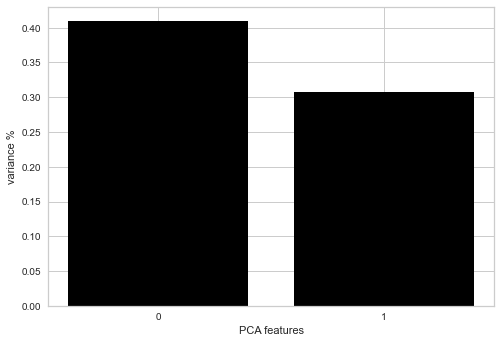

In [167]:
features = range(fullpipe.steps[1][1].n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


C:\Users\mdelan02\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


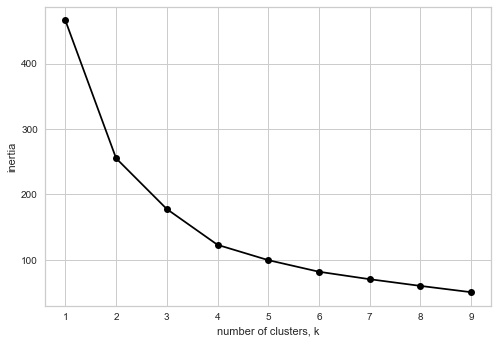

In [168]:
ks = range(1, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters = k, init='k-means++')
    fullpipe = Pipeline([('preprocess',preprocess_pipeline_pca),('pca',pca), ('kmeans',kmeans)])
    fullpipe.fit(df)
    inertias.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,10), 'Inertia':inertias})
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [169]:
kneecheck = KneeLocator(frame['Cluster'],frame['Inertia'],curve ='convex',direction='decreasing')

OptimalClusters = kneecheck.knee
print(OptimalClusters)

4


In [170]:
kmeans = KMeans(n_clusters = OptimalClusters, init='k-means++')
fullpipe = Pipeline([('preprocess',preprocess_pipeline_pca),('pca',pca), ('kmeans',kmeans)])
fullpipe.fit(newdf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('standardized',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Spending Score (1-100)',
                                                   'Annual Income (k$)',
                                                   'Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestClassifier(),
                                                                                    initial_strategy='mos

In [171]:
preprocessed_data = fullpipe["preprocess"].transform(newdf) #fullpipe.transform(newdf)
pca_data = fullpipe['pca'].transform(preprocessed_data)
predicted_labels2 = fullpipe["kmeans"].labels_

# silhouette score
print("PCA Cluster Silhouette Score           : ", silhouette_score(pca_data, predicted_labels2, metric='euclidean'))
print("Processing PCA Cluster Silhouette Score: ", silhouette_score(preprocessed_data, predicted_labels2, metric='euclidean')) 
print("Processing Cluster Silhouette Score    : ", silhouette_score(preprocessed_data_pre, predicted_labels_pre, metric='euclidean')) 

PCA Cluster Silhouette Score           :  0.4217762265394878
Processing PCA Cluster Silhouette Score:  0.31292313363118696
Processing Cluster Silhouette Score    :  0.5178061612639743


In [172]:
#PCA resulted in very little info gain


In [173]:
#mapping clusters back to the dataset

df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

frame = pd.DataFrame(df)
frame['cluster'] = predicted_labels_pre
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,2
2,Female,20,16,6,3
3,Female,23,16,77,2
4,Female,31,17,40,1


In [174]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,42.595238,54.809524,50.761905
1,1,40.741935,55.854839,45.709677
2,2,30.272727,65.036364,82.854545
3,3,43.658537,67.560976,12.609756


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

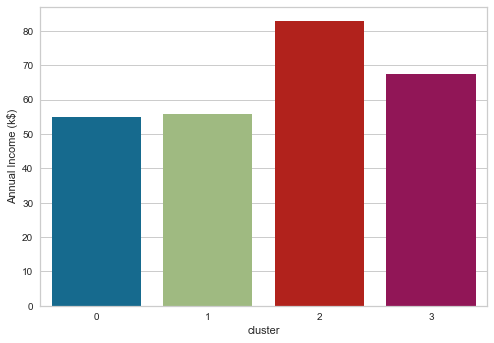

In [175]:
sns.barplot(x='cluster',y='Age',data=avg_df)
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

In [176]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2.head()

Gender
cluster Gender        
0       Male        42
1       Female      62
2       Female      33
        Male        22
3       Female      17

In [177]:
'''
KNN is a descriptive measure. For us to use this for persona's we take graphs of the variables in we see in the custers
then describe them. Why are we stopping the math and letting humans take over? This also seems like it would fail on clusters
with higher dimensionality.

Can we determine what features make a cluster important mathematically and use that to describe it?
'''

"\nKNN is a descriptive measure. For us to use this for persona's we take graphs of the variables in we see in the custers\nthen describe them. Why are we stopping the math and letting humans take over? This also seems like it would fail on clusters\nwith higher dimensionality.\n\nCan we determine what features make a cluster important mathematically and use that to describe it?\n"

In [178]:
numClusters = len(set(frame['cluster']))

frame[categ] = frame[categ].apply(le.fit_transform)

In [179]:
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,19,15,39,0
1,1,21,15,81,2
2,0,20,16,6,3
3,0,23,16,77,2
4,0,31,17,40,1


In [180]:
clusterList = []
for i in range(numClusters):
    df = frame.copy()
    df['orig_cluster'] = df['cluster']
    clusterList.append(df)

In [181]:
for n,j in enumerate(clusterList):
    j.loc[j['cluster'] != n, 'cluster'] = numClusters
    j.loc[j['cluster'] == n, 'cluster'] = 1
    j.loc[j['cluster'] == numClusters, 'cluster'] = 0

In [182]:
rf_clf = RandomForestClassifier()

In [183]:
rfPipe = Pipeline([('preprocess',preprocess_pipeline), ('rf',rf_clf)])
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)', 'Gender']

In [184]:
clusterDescDict = {}

for n,j in enumerate(clusterList):
    rfPipe.fit(j,j['cluster'])
    
    # Index sort the most important features
    sorted_feature_weight_idxes = np.argsort(rfPipe['rf'].feature_importances_)[::-1] # Reverse sort
    
    #Get the most important features and weights
    most_important_features = np.take_along_axis(
    np.array(col_names), 
    sorted_feature_weight_idxes, axis=0)
    
    most_important_weights = np.take_along_axis(
    np.array(rfPipe['rf'].feature_importances_), 
    sorted_feature_weight_idxes, axis=0)
    
    # Show
    clusterDescDict[n] = list(zip(most_important_features, most_important_weights))

In [189]:
for i in range(len(clusterDescDict)):
    print('Cluster ',i,': ')
    print(clusterDescDict[i])

Cluster  0 : 
[('Spending Score (1-100)', 0.4132989336708913), ('Gender', 0.393005611601632), ('Annual Income (k$)', 0.1040986280194456), ('Age', 0.08959682670803114)]
Cluster  1 : 
[('Spending Score (1-100)', 0.4631555339082509), ('Gender', 0.4076937427621669), ('Age', 0.0699443860883367), ('Annual Income (k$)', 0.05920633724124541)]
Cluster  2 : 
[('Spending Score (1-100)', 0.876498514196759), ('Annual Income (k$)', 0.06358873145056153), ('Age', 0.0557237719493229), ('Gender', 0.0041889824033566276)]
Cluster  3 : 
[('Spending Score (1-100)', 0.8409440076600373), ('Age', 0.08980032274113708), ('Annual Income (k$)', 0.0634512154009846), ('Gender', 0.00580445419784111)]
